In [1]:
from konlpy.tag import Mecab
from collections import Counter

import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPooling1D
from tensorflow.keras.layers import Input, Conv1D, Dropout, Concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import seaborn as sns
import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [2]:
import os

os.listdir('../../data')

['train_bt_en.csv',
 'preprocessed_train.csv',
 'train.csv',
 'test.json',
 'train_bt_ja.csv',
 'train_rd.csv',
 'train_rs.csv',
 'wordnet.pickle']

In [6]:
class ClassifierModel():
    def __init__(self, datasets=['preprocessed_train'], frac=0.5):
        super(ClassifierModel, self).__init__()
        
        self.tokenizer = Mecab()
        self.stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
        
        self.vocab_size = None
        self.word_vector_dim = 128
        
        self.x_train = None
        self.y_train = None
        self.x_test = None
        self.y_test = None
        self.x_val = None
        self.y_val = None
        
        self.preprocess(datasets, frac)
        
        self.model = self.CNN()
        self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        
        self.history = None
        self.es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

    
    def data_load(self, datasets, frac):
        
        _dir = '../../data'
        dfs = []
        for ds in datasets:
            _df = pd.read_csv(f'{_dir}/{ds}.csv')
            
            if ds != 'preprocessed_train':
                _df = _df.sample(frac=frac)
                
            dfs.append(_df)
            
        df = pd.concat(dfs)
        df.drop_duplicates(inplace=True)
        
        return df
    

    def preprocess_sentence(self, sentence):

        sentence = sentence.lower().strip()
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = re.sub(r'[" "]+', " ", sentence)
        sentence = re.sub(r"[^a-zA-Z?.!가-힣ㄱ-ㅎㅏ-ㅣ]+", " ", sentence)
        sentence = sentence.strip()

        return sentence
    
    
    def tokenize(self, it):
        result = []
        for sentence in it:
            temp = self.tokenizer.morphs(sentence)
            temp = [word for word in temp if not word in self.stopwords] 
            result.append(temp)
        return result
    
    
    def pad_sequences(self, it, word_to_index):
        return tf.keras.preprocessing.sequence.pad_sequences(
            it, value=word_to_index["<PAD>"], padding='pre', maxlen=70)
    
    
    def preprocess(self, datasets, frac):
        
        df = self.data_load(datasets, frac)
        df['data'] = df['data'].apply(lambda it : self.preprocess_sentence(it))
        
        X = self.tokenize(df['data'])
        Y = tf.keras.utils.to_categorical(df['label'], num_classes=4, dtype='float32')
        
        x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2)
        x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)
        
        self.y_train = y_train
        self.y_val = y_val
        self.y_test = y_test
        
        words = np.concatenate(x_train).tolist()
        counter = Counter(words)
        counter = counter.most_common(10000-4)
        vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
        word_to_index = { word:index for index, word in enumerate(vocab) }
        
        self.vocab_size = len(word_to_index)
        
        def wordlist_to_index_list(wordlist):
            return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
        x_train = list(map(wordlist_to_index_list, x_train))
        x_test = list(map(wordlist_to_index_list, x_test))
        x_val = list(map(wordlist_to_index_list, x_val))  
        
        self.x_train = self.pad_sequences(x_train, word_to_index)
        self.x_val = self.pad_sequences(x_val, word_to_index)
        self.x_test = self.pad_sequences(x_test, word_to_index)
    

    def CNN(self):
    
        inputs = Input(shape=(None, ))
        embedding = Embedding(self.vocab_size, self.word_vector_dim)(inputs)

        branches = []
        for filter_size in [3, 3]:
            branch = Conv1D(64, filter_size, activation='relu')(embedding)
            branch = GlobalMaxPooling1D()(branch)
            branches.append(branch)

        out = Concatenate()(branches)
        out = Dense(32, activation='relu')(out)
        out = Dropout(0.5)(out)

        out = Dense(4, activation='softmax')(out)
        model = Model(inputs=inputs, outputs=out)

        return model
    
    def train(self):
        self.history = self.model.fit(
            self.x_train, self.y_train, epochs=20, batch_size=64,
            validation_data=(self.x_val, self.y_val), callbacks=self.es, verbose=1)
        
    def show_report(self):
        y_pred = self.model.predict(self.x_test).argmax(axis=1)
        y_true = self.y_test.argmax(axis=1)
        
        print(f'accuracy : {accuracy_score(y_true, y_pred)}')
        print(f'macro f1 : {f1_score(y_true, y_pred, average="macro")}')
        print(f'weighted f1 : {f1_score(y_true, y_pred, average="weighted")}')
        
        conf_matrix = confusion_matrix(y_true, y_pred)
        names = ["협박", "갈취", "직장내 괴롭힘", "기타 괴롭힘"]
        conf_matrix = pd.DataFrame(conf_matrix, index=names, columns=names)
        sns.heatmap(conf_matrix, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.show()

Epoch 1/20
50/50 [==============================] - 1s 8ms/step - loss: 1.3163 - accuracy: 0.4006 - val_loss: 1.1900 - val_accuracy: 0.5628
Epoch 2/20
50/50 [==============================] - 0s 6ms/step - loss: 1.0231 - accuracy: 0.6149 - val_loss: 0.8723 - val_accuracy: 0.6599
Epoch 3/20
50/50 [==============================] - 0s 5ms/step - loss: 0.7319 - accuracy: 0.7446 - val_loss: 0.6597 - val_accuracy: 0.7702
Epoch 4/20
50/50 [==============================] - 0s 5ms/step - loss: 0.5098 - accuracy: 0.8430 - val_loss: 0.5268 - val_accuracy: 0.8279
Epoch 5/20
50/50 [==============================] - 0s 5ms/step - loss: 0.3300 - accuracy: 0.9123 - val_loss: 0.4639 - val_accuracy: 0.8360
Epoch 6/20
50/50 [==============================] - 0s 6ms/step - loss: 0.2133 - accuracy: 0.9472 - val_loss: 0.4360 - val_accuracy: 0.8512
Epoch 7/20
50/50 [==============================] - 0s 6ms/step - loss: 0.1459 - accuracy: 0.9687 - val_loss: 0.4355 - val_accuracy: 0.8502
Epoch 8/20
50/50 [==

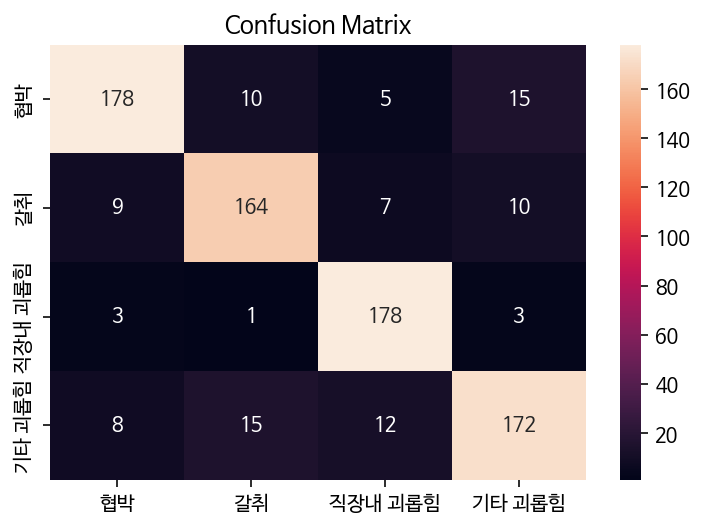

In [7]:
rs_25 = ClassifierModel(datasets=['preprocessed_train', 'train_rs'], frac=0.25)
rs_25.train()
rs_25.show_report()

Epoch 1/20
60/60 [==============================] - 2s 17ms/step - loss: 1.2963 - accuracy: 0.4272 - val_loss: 1.0786 - val_accuracy: 0.6776
Epoch 2/20
60/60 [==============================] - 0s 5ms/step - loss: 0.9206 - accuracy: 0.6690 - val_loss: 0.6601 - val_accuracy: 0.7806
Epoch 3/20
60/60 [==============================] - 0s 6ms/step - loss: 0.5723 - accuracy: 0.8096 - val_loss: 0.4645 - val_accuracy: 0.8523
Epoch 4/20
60/60 [==============================] - 0s 5ms/step - loss: 0.3738 - accuracy: 0.8863 - val_loss: 0.3837 - val_accuracy: 0.8709
Epoch 5/20
60/60 [==============================] - 0s 5ms/step - loss: 0.2396 - accuracy: 0.9393 - val_loss: 0.3469 - val_accuracy: 0.8776
Epoch 6/20
60/60 [==============================] - 0s 5ms/step - loss: 0.1400 - accuracy: 0.9702 - val_loss: 0.3242 - val_accuracy: 0.8878
Epoch 7/20
60/60 [==============================] - 0s 5ms/step - loss: 0.0962 - accuracy: 0.9786 - val_loss: 0.3260 - val_accuracy: 0.8945
Epoch 8/20
60/60 [=

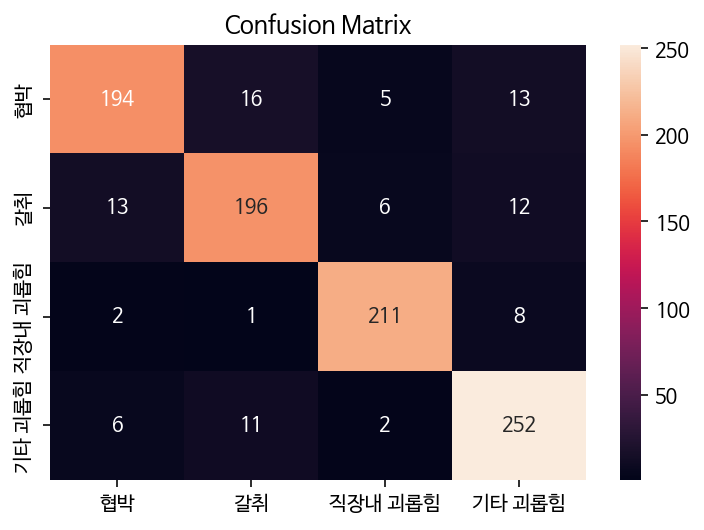

In [9]:
rs_50 = ClassifierModel(datasets=['preprocessed_train', 'train_rs'], frac=0.50)
rs_50.train()
rs_50.show_report()

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 1.2905 - accuracy: 0.4201 - val_loss: 1.0842 - val_accuracy: 0.6710
Epoch 2/20
70/70 [==============================] - 0s 5ms/step - loss: 0.9103 - accuracy: 0.6629 - val_loss: 0.6658 - val_accuracy: 0.7701
Epoch 3/20
70/70 [==============================] - 0s 5ms/step - loss: 0.6024 - accuracy: 0.7888 - val_loss: 0.4988 - val_accuracy: 0.8279
Epoch 4/20
70/70 [==============================] - 0s 5ms/step - loss: 0.4038 - accuracy: 0.8736 - val_loss: 0.4126 - val_accuracy: 0.8561
Epoch 5/20
70/70 [==============================] - 0s 5ms/step - loss: 0.2562 - accuracy: 0.9270 - val_loss: 0.3774 - val_accuracy: 0.8684
Epoch 6/20
70/70 [==============================] - 0s 5ms/step - loss: 0.1784 - accuracy: 0.9507 - val_loss: 0.3545 - val_accuracy: 0.8886
Epoch 7/20
70/70 [==============================] - 0s 5ms/step - loss: 0.1228 - accuracy: 0.9647 - val_loss: 0.3492 - val_accuracy: 0.8872
Epoch 8/20
70/70 [=

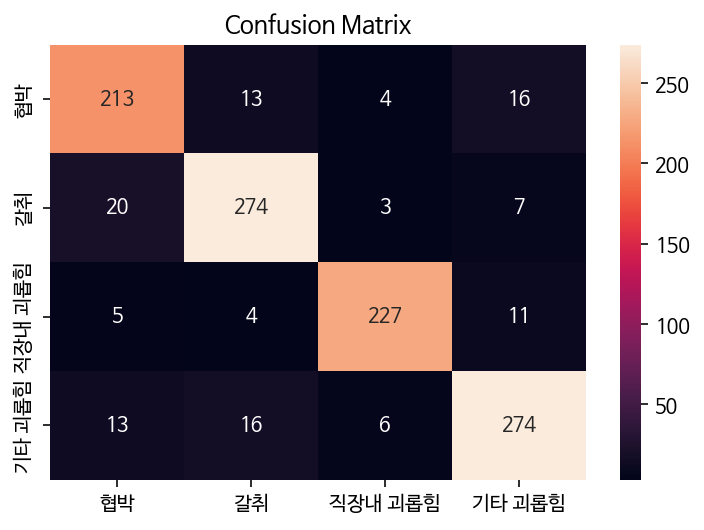

In [10]:
rs_75 = ClassifierModel(datasets=['preprocessed_train', 'train_rs'], frac=0.75)
rs_75.train()
rs_75.show_report()

Epoch 1/20
79/79 [==============================] - 1s 8ms/step - loss: 1.2956 - accuracy: 0.4051 - val_loss: 1.0677 - val_accuracy: 0.6525
Epoch 2/20
79/79 [==============================] - 0s 5ms/step - loss: 0.8500 - accuracy: 0.6984 - val_loss: 0.5954 - val_accuracy: 0.7962
Epoch 3/20
79/79 [==============================] - 0s 4ms/step - loss: 0.5005 - accuracy: 0.8386 - val_loss: 0.4373 - val_accuracy: 0.8487
Epoch 4/20
79/79 [==============================] - 0s 4ms/step - loss: 0.3037 - accuracy: 0.9124 - val_loss: 0.3501 - val_accuracy: 0.8861
Epoch 5/20
79/79 [==============================] - 0s 5ms/step - loss: 0.1862 - accuracy: 0.9523 - val_loss: 0.3100 - val_accuracy: 0.9013
Epoch 6/20
79/79 [==============================] - 0s 4ms/step - loss: 0.1213 - accuracy: 0.9705 - val_loss: 0.2925 - val_accuracy: 0.9082
Epoch 7/20
79/79 [==============================] - 0s 4ms/step - loss: 0.0781 - accuracy: 0.9818 - val_loss: 0.2919 - val_accuracy: 0.9108
Epoch 8/20
79/79 [==

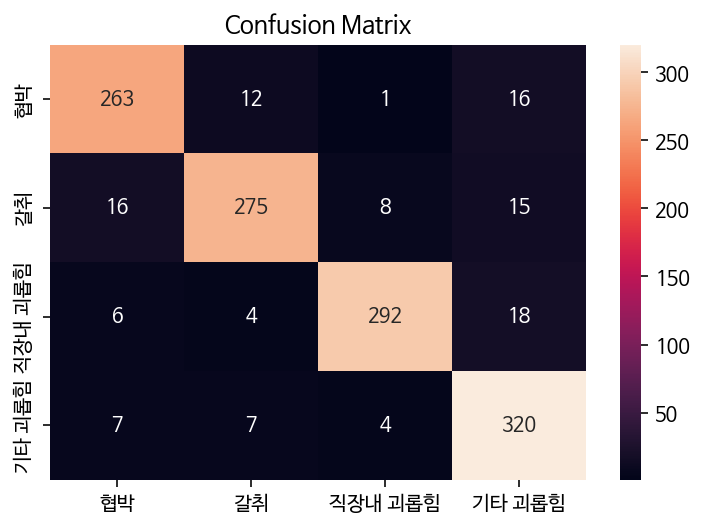

In [11]:
rs_100 = ClassifierModel(datasets=['preprocessed_train', 'train_rs'], frac=1)
rs_100.train()
rs_100.show_report()

Epoch 1/20
50/50 [==============================] - 1s 9ms/step - loss: 1.3160 - accuracy: 0.4066 - val_loss: 1.1486 - val_accuracy: 0.6154
Epoch 2/20
50/50 [==============================] - 0s 6ms/step - loss: 0.9926 - accuracy: 0.6481 - val_loss: 0.7852 - val_accuracy: 0.7470
Epoch 3/20
50/50 [==============================] - 0s 5ms/step - loss: 0.6809 - accuracy: 0.7684 - val_loss: 0.5840 - val_accuracy: 0.7854
Epoch 4/20
50/50 [==============================] - 0s 6ms/step - loss: 0.4675 - accuracy: 0.8528 - val_loss: 0.4846 - val_accuracy: 0.8300
Epoch 5/20
50/50 [==============================] - 0s 5ms/step - loss: 0.3073 - accuracy: 0.9180 - val_loss: 0.4323 - val_accuracy: 0.8411
Epoch 6/20
50/50 [==============================] - 0s 5ms/step - loss: 0.2001 - accuracy: 0.9560 - val_loss: 0.4136 - val_accuracy: 0.8512
Epoch 7/20
50/50 [==============================] - 0s 6ms/step - loss: 0.1394 - accuracy: 0.9731 - val_loss: 0.4027 - val_accuracy: 0.8553
Epoch 8/20
50/50 [==

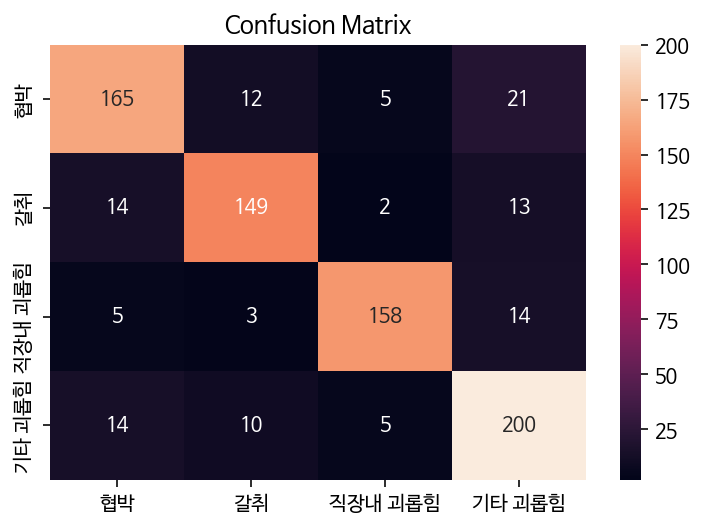

In [12]:
rd_25 = ClassifierModel(datasets=['preprocessed_train', 'train_rd'], frac=0.25)
rd_25.train()
rd_25.show_report()

Epoch 1/20
60/60 [==============================] - 1s 8ms/step - loss: 1.3366 - accuracy: 0.3887 - val_loss: 1.2035 - val_accuracy: 0.6624
Epoch 2/20
60/60 [==============================] - 0s 5ms/step - loss: 1.0014 - accuracy: 0.6261 - val_loss: 0.7421 - val_accuracy: 0.7350
Epoch 3/20
60/60 [==============================] - 0s 6ms/step - loss: 0.6805 - accuracy: 0.7627 - val_loss: 0.5551 - val_accuracy: 0.8160
Epoch 4/20
60/60 [==============================] - 0s 5ms/step - loss: 0.4642 - accuracy: 0.8552 - val_loss: 0.4559 - val_accuracy: 0.8422
Epoch 5/20
60/60 [==============================] - 0s 5ms/step - loss: 0.3147 - accuracy: 0.9109 - val_loss: 0.4103 - val_accuracy: 0.8574
Epoch 6/20
60/60 [==============================] - 0s 5ms/step - loss: 0.2019 - accuracy: 0.9470 - val_loss: 0.3996 - val_accuracy: 0.8582
Epoch 7/20
60/60 [==============================] - 0s 5ms/step - loss: 0.1288 - accuracy: 0.9686 - val_loss: 0.4029 - val_accuracy: 0.8658
Epoch 8/20
60/60 [==

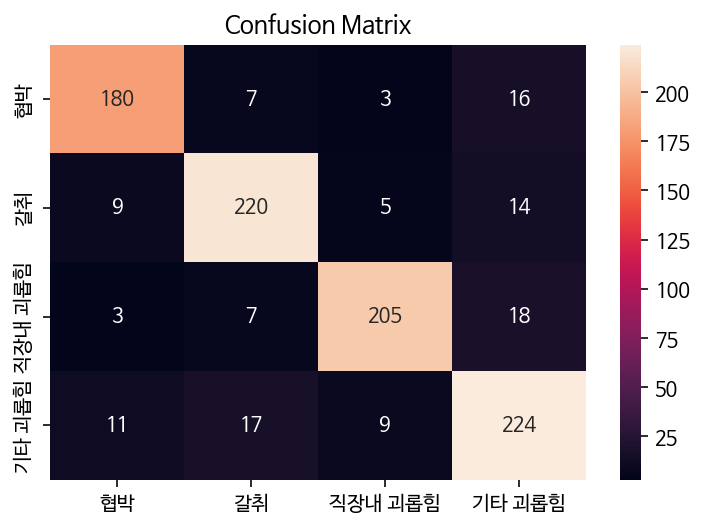

In [13]:
rd_50 = ClassifierModel(datasets=['preprocessed_train', 'train_rd'], frac=0.50)
rd_50.train()
rd_50.show_report()

Epoch 1/20
70/70 [==============================] - 1s 8ms/step - loss: 1.2832 - accuracy: 0.4495 - val_loss: 1.0203 - val_accuracy: 0.6652
Epoch 2/20
70/70 [==============================] - 0s 5ms/step - loss: 0.8485 - accuracy: 0.6934 - val_loss: 0.6248 - val_accuracy: 0.7932
Epoch 3/20
70/70 [==============================] - 0s 5ms/step - loss: 0.5518 - accuracy: 0.8234 - val_loss: 0.4790 - val_accuracy: 0.8366
Epoch 4/20
70/70 [==============================] - 0s 5ms/step - loss: 0.3576 - accuracy: 0.8946 - val_loss: 0.3962 - val_accuracy: 0.8561
Epoch 5/20
70/70 [==============================] - 0s 5ms/step - loss: 0.2347 - accuracy: 0.9371 - val_loss: 0.3509 - val_accuracy: 0.8792
Epoch 6/20
70/70 [==============================] - 0s 6ms/step - loss: 0.1446 - accuracy: 0.9645 - val_loss: 0.3376 - val_accuracy: 0.8858
Epoch 7/20
70/70 [==============================] - 0s 5ms/step - loss: 0.0949 - accuracy: 0.9808 - val_loss: 0.3368 - val_accuracy: 0.8879
Epoch 8/20
70/70 [==

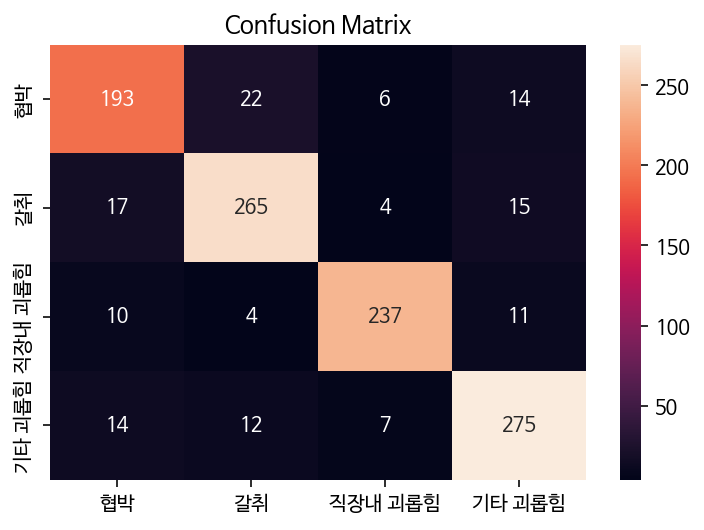

In [14]:
rd_75 = ClassifierModel(datasets=['preprocessed_train', 'train_rd'], frac=0.75)
rd_75.train()
rd_75.show_report()

Epoch 1/20
79/79 [==============================] - 1s 7ms/step - loss: 1.2787 - accuracy: 0.4357 - val_loss: 1.0259 - val_accuracy: 0.6430
Epoch 2/20
79/79 [==============================] - 0s 5ms/step - loss: 0.8761 - accuracy: 0.6752 - val_loss: 0.6252 - val_accuracy: 0.8038
Epoch 3/20
79/79 [==============================] - 0s 4ms/step - loss: 0.5556 - accuracy: 0.8214 - val_loss: 0.4240 - val_accuracy: 0.8671
Epoch 4/20
79/79 [==============================] - 0s 4ms/step - loss: 0.3435 - accuracy: 0.9029 - val_loss: 0.3375 - val_accuracy: 0.8937
Epoch 5/20
79/79 [==============================] - 0s 5ms/step - loss: 0.2098 - accuracy: 0.9434 - val_loss: 0.2924 - val_accuracy: 0.8994
Epoch 6/20
79/79 [==============================] - 0s 5ms/step - loss: 0.1318 - accuracy: 0.9676 - val_loss: 0.2827 - val_accuracy: 0.9076
Epoch 7/20
79/79 [==============================] - 0s 5ms/step - loss: 0.0903 - accuracy: 0.9743 - val_loss: 0.2854 - val_accuracy: 0.9076
Epoch 8/20
79/79 [==

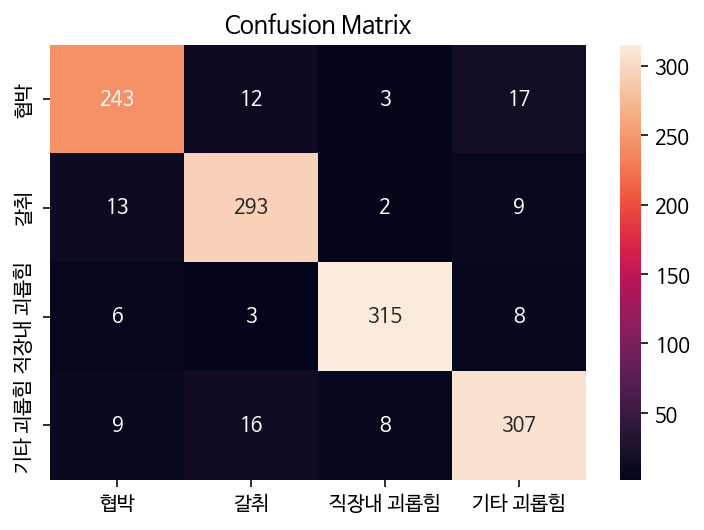

In [15]:
rd_100 = ClassifierModel(datasets=['preprocessed_train', 'train_rd'], frac=1)
rd_100.train()
rd_100.show_report()

Epoch 1/20
50/50 [==============================] - 1s 9ms/step - loss: 1.3532 - accuracy: 0.3519 - val_loss: 1.2522 - val_accuracy: 0.6063
Epoch 2/20
50/50 [==============================] - 0s 6ms/step - loss: 1.0945 - accuracy: 0.5902 - val_loss: 0.8495 - val_accuracy: 0.7156
Epoch 3/20
50/50 [==============================] - 0s 6ms/step - loss: 0.7637 - accuracy: 0.7329 - val_loss: 0.6264 - val_accuracy: 0.7702
Epoch 4/20
50/50 [==============================] - 0s 6ms/step - loss: 0.5398 - accuracy: 0.8247 - val_loss: 0.5343 - val_accuracy: 0.8148
Epoch 5/20
50/50 [==============================] - 0s 6ms/step - loss: 0.3581 - accuracy: 0.8984 - val_loss: 0.4677 - val_accuracy: 0.8330
Epoch 6/20
50/50 [==============================] - 0s 5ms/step - loss: 0.2211 - accuracy: 0.9487 - val_loss: 0.4498 - val_accuracy: 0.8360
Epoch 7/20
50/50 [==============================] - 0s 5ms/step - loss: 0.1451 - accuracy: 0.9744 - val_loss: 0.4585 - val_accuracy: 0.8391
Epoch 8/20
50/50 [==

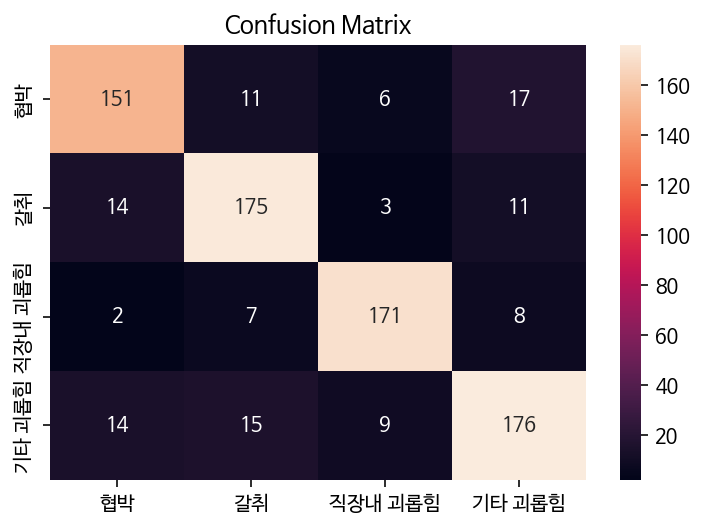

In [16]:
bt_en_25 = ClassifierModel(datasets=['preprocessed_train', 'train_bt_en'], frac=0.25)
bt_en_25.train()
bt_en_25.show_report()

Epoch 1/20
60/60 [==============================] - 1s 8ms/step - loss: 1.3334 - accuracy: 0.3850 - val_loss: 1.2037 - val_accuracy: 0.6135
Epoch 2/20
60/60 [==============================] - 0s 5ms/step - loss: 1.0014 - accuracy: 0.6271 - val_loss: 0.7444 - val_accuracy: 0.7561
Epoch 3/20
60/60 [==============================] - 0s 5ms/step - loss: 0.6831 - accuracy: 0.7795 - val_loss: 0.5547 - val_accuracy: 0.8127
Epoch 4/20
60/60 [==============================] - 0s 5ms/step - loss: 0.4594 - accuracy: 0.8555 - val_loss: 0.4614 - val_accuracy: 0.8312
Epoch 5/20
60/60 [==============================] - 0s 5ms/step - loss: 0.3100 - accuracy: 0.9169 - val_loss: 0.4193 - val_accuracy: 0.8523
Epoch 6/20
60/60 [==============================] - 0s 5ms/step - loss: 0.2057 - accuracy: 0.9444 - val_loss: 0.4085 - val_accuracy: 0.8489
Epoch 7/20
60/60 [==============================] - 0s 5ms/step - loss: 0.1308 - accuracy: 0.9707 - val_loss: 0.4028 - val_accuracy: 0.8557
Epoch 8/20
60/60 [==

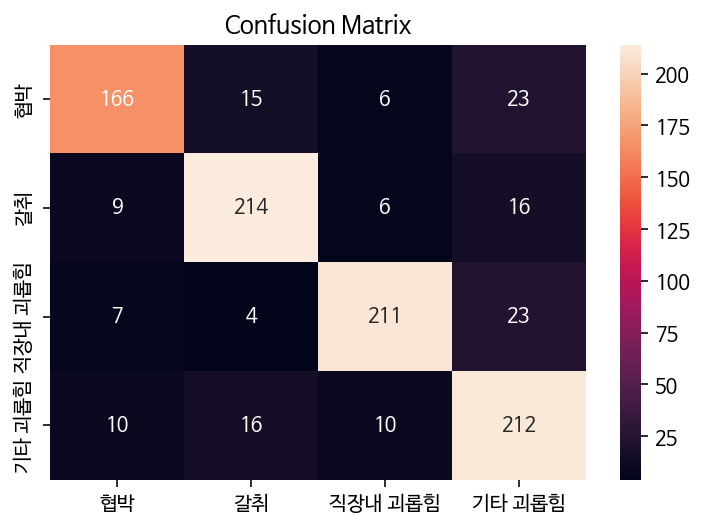

In [17]:
bt_en_50 = ClassifierModel(datasets=['preprocessed_train', 'train_bt_en'], frac=0.5)
bt_en_50.train()
bt_en_50.show_report()

Epoch 1/20
70/70 [==============================] - 1s 8ms/step - loss: 1.3193 - accuracy: 0.3830 - val_loss: 1.1434 - val_accuracy: 0.6327
Epoch 2/20
70/70 [==============================] - 0s 6ms/step - loss: 0.9523 - accuracy: 0.6414 - val_loss: 0.7516 - val_accuracy: 0.7534
Epoch 3/20
70/70 [==============================] - 0s 5ms/step - loss: 0.6315 - accuracy: 0.7872 - val_loss: 0.5917 - val_accuracy: 0.7932
Epoch 4/20
70/70 [==============================] - 0s 5ms/step - loss: 0.4140 - accuracy: 0.8736 - val_loss: 0.4860 - val_accuracy: 0.8250
Epoch 5/20
70/70 [==============================] - 0s 6ms/step - loss: 0.2700 - accuracy: 0.9256 - val_loss: 0.4516 - val_accuracy: 0.8431
Epoch 6/20
70/70 [==============================] - 0s 5ms/step - loss: 0.1827 - accuracy: 0.9548 - val_loss: 0.4390 - val_accuracy: 0.8474
Epoch 7/20
70/70 [==============================] - 0s 5ms/step - loss: 0.1116 - accuracy: 0.9760 - val_loss: 0.4540 - val_accuracy: 0.8510
Epoch 8/20
70/70 [==

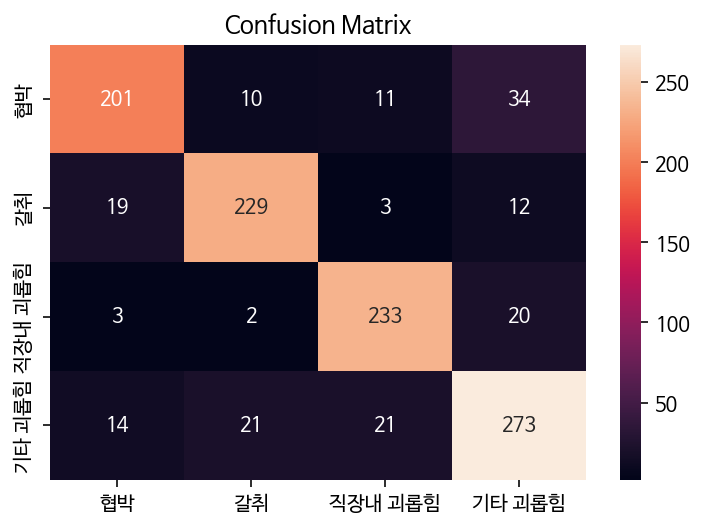

In [18]:
bt_en_75 = ClassifierModel(datasets=['preprocessed_train', 'train_bt_en'], frac=0.75)
bt_en_75.train()
bt_en_75.show_report()

Epoch 1/20
79/79 [==============================] - 1s 7ms/step - loss: 1.3094 - accuracy: 0.4098 - val_loss: 1.0497 - val_accuracy: 0.6576
Epoch 2/20
79/79 [==============================] - 0s 5ms/step - loss: 0.9045 - accuracy: 0.6760 - val_loss: 0.6438 - val_accuracy: 0.7930
Epoch 3/20
79/79 [==============================] - 0s 5ms/step - loss: 0.5928 - accuracy: 0.8103 - val_loss: 0.4724 - val_accuracy: 0.8443
Epoch 4/20
79/79 [==============================] - 0s 4ms/step - loss: 0.3632 - accuracy: 0.8926 - val_loss: 0.4042 - val_accuracy: 0.8646
Epoch 5/20
79/79 [==============================] - 0s 5ms/step - loss: 0.2172 - accuracy: 0.9422 - val_loss: 0.3851 - val_accuracy: 0.8658
Epoch 6/20
79/79 [==============================] - 0s 5ms/step - loss: 0.1212 - accuracy: 0.9749 - val_loss: 0.3733 - val_accuracy: 0.8728
Epoch 7/20
79/79 [==============================] - 0s 5ms/step - loss: 0.0768 - accuracy: 0.9848 - val_loss: 0.3992 - val_accuracy: 0.8734
Epoch 8/20
79/79 [==

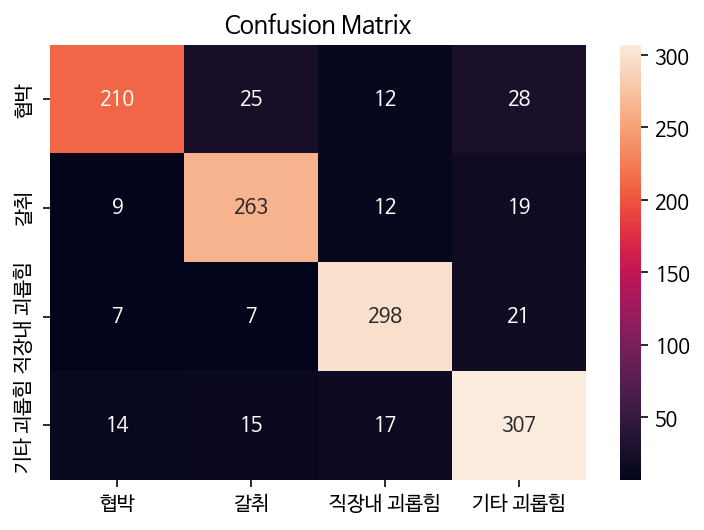

In [19]:
bt_en_100 = ClassifierModel(datasets=['preprocessed_train', 'train_bt_en'], frac=1)
bt_en_100.train()
bt_en_100.show_report()

Epoch 1/20
50/50 [==============================] - 1s 9ms/step - loss: 1.3348 - accuracy: 0.3845 - val_loss: 1.2265 - val_accuracy: 0.5172
Epoch 2/20
50/50 [==============================] - 0s 6ms/step - loss: 1.0587 - accuracy: 0.5981 - val_loss: 0.8828 - val_accuracy: 0.6781
Epoch 3/20
50/50 [==============================] - 0s 6ms/step - loss: 0.7512 - accuracy: 0.7415 - val_loss: 0.6705 - val_accuracy: 0.7571
Epoch 4/20
50/50 [==============================] - 0s 6ms/step - loss: 0.5369 - accuracy: 0.8332 - val_loss: 0.5703 - val_accuracy: 0.8026
Epoch 5/20
50/50 [==============================] - 0s 5ms/step - loss: 0.3694 - accuracy: 0.8981 - val_loss: 0.5251 - val_accuracy: 0.8087
Epoch 6/20
50/50 [==============================] - 0s 6ms/step - loss: 0.2321 - accuracy: 0.9462 - val_loss: 0.5086 - val_accuracy: 0.8239
Epoch 7/20
50/50 [==============================] - 0s 5ms/step - loss: 0.1528 - accuracy: 0.9665 - val_loss: 0.5190 - val_accuracy: 0.8289
Epoch 8/20
50/50 [==

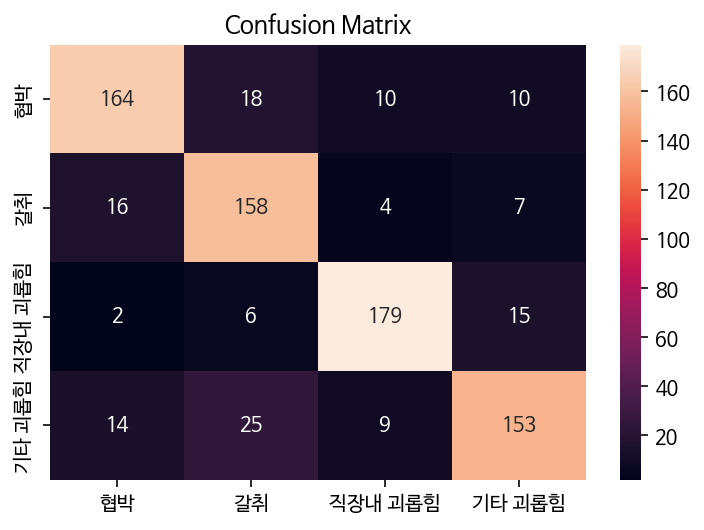

In [20]:
bt_ja_25 = ClassifierModel(datasets=['preprocessed_train', 'train_bt_ja'], frac=0.25)
bt_ja_25.train()
bt_ja_25.show_report()

Epoch 1/20
60/60 [==============================] - 1s 8ms/step - loss: 1.3411 - accuracy: 0.3724 - val_loss: 1.2349 - val_accuracy: 0.6287
Epoch 2/20
60/60 [==============================] - 0s 5ms/step - loss: 1.0401 - accuracy: 0.6158 - val_loss: 0.8444 - val_accuracy: 0.7021
Epoch 3/20
60/60 [==============================] - 0s 5ms/step - loss: 0.7442 - accuracy: 0.7426 - val_loss: 0.6230 - val_accuracy: 0.7789
Epoch 4/20
60/60 [==============================] - 0s 5ms/step - loss: 0.5182 - accuracy: 0.8362 - val_loss: 0.5282 - val_accuracy: 0.8084
Epoch 5/20
60/60 [==============================] - 0s 5ms/step - loss: 0.3386 - accuracy: 0.9027 - val_loss: 0.4660 - val_accuracy: 0.8304
Epoch 6/20
60/60 [==============================] - 0s 5ms/step - loss: 0.2253 - accuracy: 0.9433 - val_loss: 0.4456 - val_accuracy: 0.8287
Epoch 7/20
60/60 [==============================] - 0s 5ms/step - loss: 0.1452 - accuracy: 0.9649 - val_loss: 0.4423 - val_accuracy: 0.8405
Epoch 8/20
60/60 [==

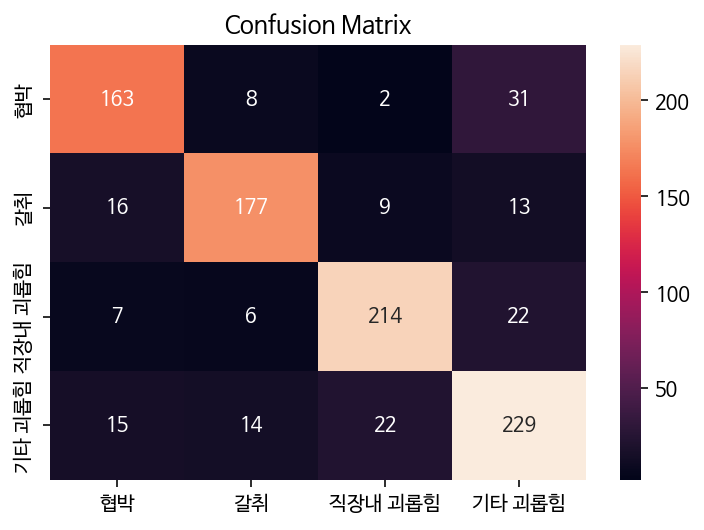

In [21]:
bt_ja_50 = ClassifierModel(datasets=['preprocessed_train', 'train_bt_ja'], frac=0.5)
bt_ja_50.train()
bt_ja_50.show_report()

Epoch 1/20
70/70 [==============================] - 1s 8ms/step - loss: 1.3032 - accuracy: 0.4117 - val_loss: 1.1175 - val_accuracy: 0.5423
Epoch 2/20
70/70 [==============================] - 0s 5ms/step - loss: 0.9839 - accuracy: 0.6095 - val_loss: 0.7890 - val_accuracy: 0.7050
Epoch 3/20
70/70 [==============================] - 0s 5ms/step - loss: 0.6892 - accuracy: 0.7567 - val_loss: 0.6050 - val_accuracy: 0.7867
Epoch 4/20
70/70 [==============================] - 0s 5ms/step - loss: 0.4720 - accuracy: 0.8519 - val_loss: 0.5194 - val_accuracy: 0.8026
Epoch 5/20
70/70 [==============================] - 0s 6ms/step - loss: 0.3096 - accuracy: 0.9075 - val_loss: 0.4774 - val_accuracy: 0.8301
Epoch 6/20
70/70 [==============================] - 0s 6ms/step - loss: 0.2075 - accuracy: 0.9527 - val_loss: 0.4784 - val_accuracy: 0.8279
Epoch 7/20
70/70 [==============================] - 0s 5ms/step - loss: 0.1417 - accuracy: 0.9679 - val_loss: 0.4837 - val_accuracy: 0.8351
Epoch 8/20
70/70 [==

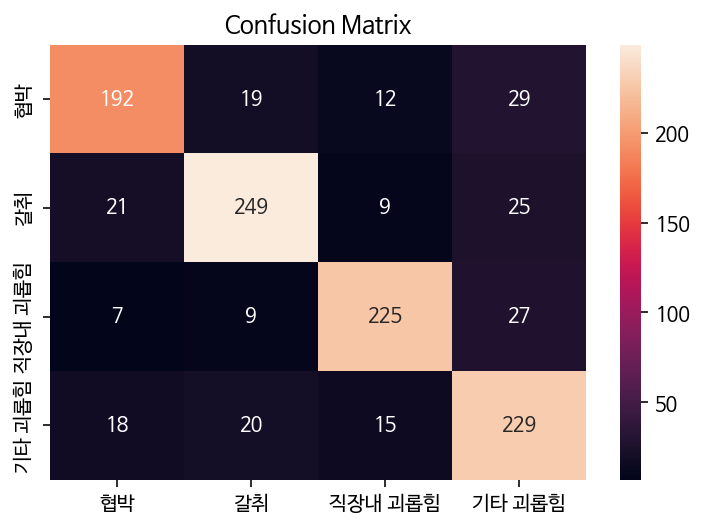

In [22]:
bt_ja_75 = ClassifierModel(datasets=['preprocessed_train', 'train_bt_ja'], frac=0.75)
bt_ja_75.train()
bt_ja_75.show_report()

Epoch 1/20
79/79 [==============================] - 1s 7ms/step - loss: 1.3004 - accuracy: 0.4055 - val_loss: 1.0831 - val_accuracy: 0.6532
Epoch 2/20
79/79 [==============================] - 0s 5ms/step - loss: 0.9177 - accuracy: 0.6612 - val_loss: 0.6695 - val_accuracy: 0.7810
Epoch 3/20
79/79 [==============================] - 0s 5ms/step - loss: 0.6161 - accuracy: 0.7981 - val_loss: 0.5401 - val_accuracy: 0.8196
Epoch 4/20
79/79 [==============================] - 0s 4ms/step - loss: 0.4158 - accuracy: 0.8797 - val_loss: 0.4794 - val_accuracy: 0.8278
Epoch 5/20
79/79 [==============================] - 0s 5ms/step - loss: 0.2787 - accuracy: 0.9260 - val_loss: 0.4585 - val_accuracy: 0.8399
Epoch 6/20
79/79 [==============================] - 0s 5ms/step - loss: 0.1784 - accuracy: 0.9598 - val_loss: 0.4868 - val_accuracy: 0.8354
Epoch 7/20
79/79 [==============================] - 0s 4ms/step - loss: 0.1142 - accuracy: 0.9717 - val_loss: 0.5060 - val_accuracy: 0.8266
Epoch 8/20
79/79 [==

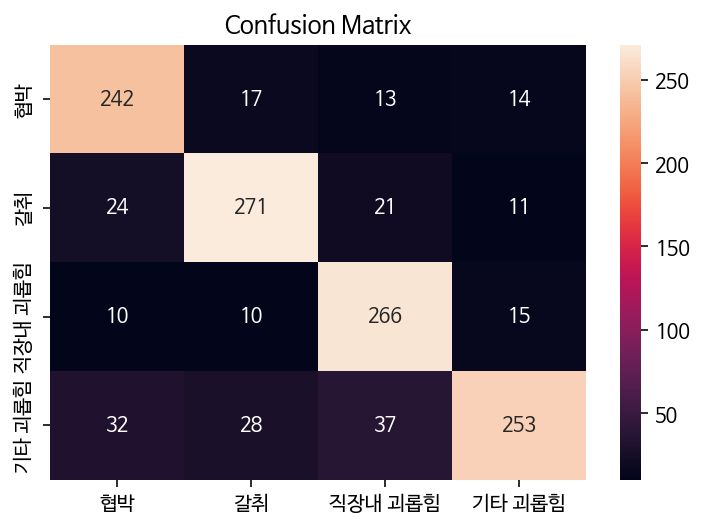

In [23]:
bt_ja_100 = ClassifierModel(datasets=['preprocessed_train', 'train_bt_ja'], frac=1)
bt_ja_100.train()
bt_ja_100.show_report()